<a href="https://colab.research.google.com/github/luqmanrofifm/Daily-Temperature-Time-Series/blob/main/Submission_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
df = pd.read_csv('Melbourne_daily_temperature.csv')
df.head()

,Time,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
df.isnull().sum()

Time           0
Temperature    0
dtype: int64

Plot Dataset

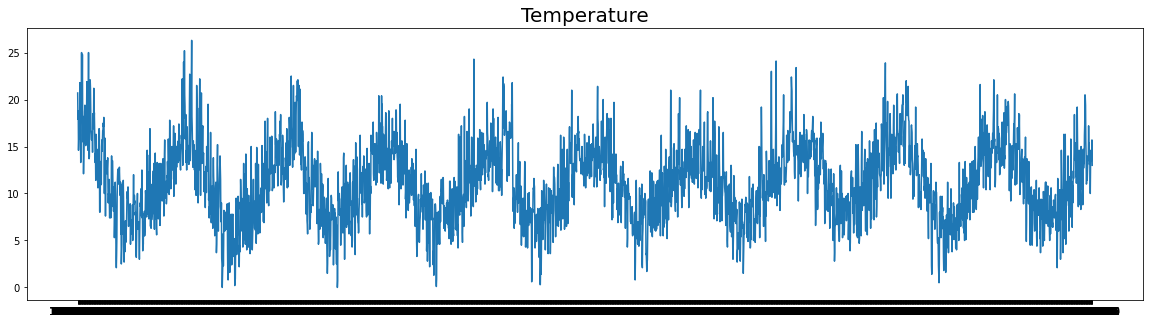

In [ ]:
dates = df['Time'].values
temp = df['Temperature'].values
plt.figure(figsize=(20,5))
plt.plot(dates, temp)
plt.title('Temperature',
          fontsize=20);

Split Dataset


In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, val = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(val))

2920 730


In [ ]:
dates_train = train['Time'].values
temp_train  = train['Temperature'].values
train.head()

,Time,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
dates_val = val['Time'].values
temp_val = val['Temperature'].values
val.head()

,Time,Temperature
2920,1989-01-01,14.3
2921,1989-01-02,17.4
2922,1989-01-03,18.5
2923,1989-01-04,16.8
2924,1989-01-05,11.5


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

Membuat Model

In [ ]:
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(temp_val, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.3):
      print("MAE sudah mencapai kurang dari 2.3")
      self.model.stop_training = True
callbacks = myCallback()

Train Model

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(
    train_set,
    validation_data = val_set,
    epochs=100,
    shuffle = False,
    callbacks=[callbacks]
    )

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 4s 122ms/step - loss: 10.3244 - mae: 10.8233 - val_loss: 10.3751 - val_mae: 10.8746
Epoch 2/100
29/29 [==============================] - 3s 98ms/step - loss: 10.0310 - mae: 10.5298 - val_loss: 10.0185 - val_mae: 10.5178
Epoch 3/100
29/29 [==============================] - 3s 99ms/step - loss: 9.6244 - mae: 10.1230 - val_loss: 9.5827 - val_mae: 10.0819
Epoch 4/100
29/29 [==============================] - 3s 101ms/step - loss: 9.1666 - mae: 9.6652 - val

Plot Hasil Train


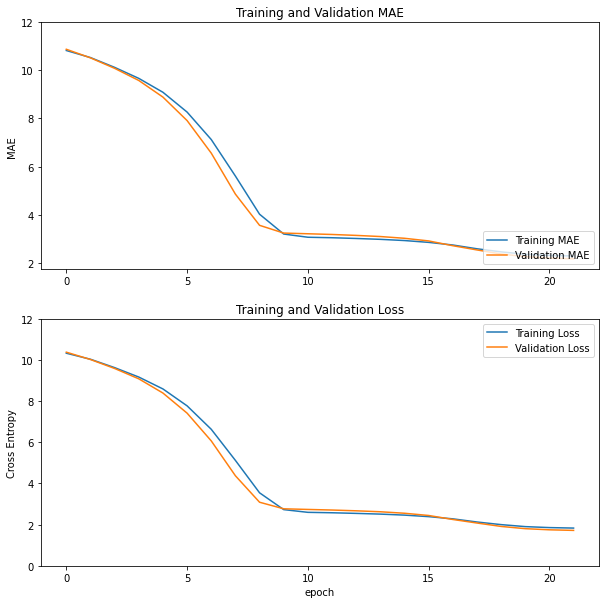

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.ylabel('MAE')
plt.ylim([min(plt.ylim()),12])
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,12.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()